# Trung Nguyen - 111752939
# Anh Quang Do - 110922124
## Assignment #3: Data Integration and Modeling 

## Task 1 (10%)

> - Build a scoring function to rank houses by “desirability”, presumably a notion related to cost or value.  
- Identify what the ten most desirable and least desirable houses in the Kaggle data set are.
- Write a one page description of which variables your function used and how well you think it worked. 

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import math
from sklearn import datasets, linear_model, preprocessing
from sklearn.metrics import mean_squared_error, r2_score, pairwise
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.cluster import MiniBatchKMeans
import warnings
from scipy.spatial import distance
from geopy.geocoders import Nominatim
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('./data/properties_2017.csv', low_memory=False)
# Calculate mean value and replace NaN values with mean value

There are fields whose values are numercal but they should be listed as categorical, since their numerical values does not reflex the level of affection to the model (Such as ``typeid`` fields). Changing each of their value to a new binary feature would be the right way to extract information from them, but then the model becomes very complex with too many features, so I simply dropped them.

I also dropped all binary fields, as I don't have experience with handling both categorical features and numerical features in the same model.

I also dropped all fields whose whose the ratio of NaN values > 25%

Finally, I replaced all NaN values in  whose 

In [5]:
df_dropped = df.drop(["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", 
                            "fireplaceflag", "taxdelinquencyflag", "assessmentyear", 
                            "airconditioningtypeid", "buildingclasstypeid", "decktypeid",
                            "heatingorsystemtypeid", "regionidcity", "regionidcounty",
                            "poolcnt", "fips", "threequarterbathnbr",
                            "regionidneighborhood", "regionidzip", "storytypeid",
                            "pooltypeid7", "rawcensustractandblock", "censustractandblock",
                            "typeconstructiontypeid", "pooltypeid10", "pooltypeid2", 
                            "architecturalstyletypeid", "bathroomcnt", "propertylandusetypeid"], axis=1)
# df_dropped_filled0 = df_dropped.fillna(0)
row, column = df_dropped.shape

In [6]:
# Drop all columns whose the ratio of NaN values > 50%
df_dropped1 = df_dropped.copy()
row, column = df_dropped1.shape
for x in df_dropped1:
    if df_dropped1[str(x)].isnull().sum() > row*0.5:
        df_dropped1.drop(str(x), axis=1, inplace=True)

In [7]:
for x in df_dropped1:
    # 'np.nanmean' finds mean by ignoring NaN values, we then replace NaN values with the result
    median = np.nanmedian(df_dropped1[str(x)])
    df_dropped1[str(x)].fillna(value=median, inplace=True)
#     for i,y in enumerate(df_dropped1[str(x)]):
#         if y=='nan' or y=="nan" or math.isnan(y):
#             df_dropped1[str(x)][i] = median

In [8]:
df_dropped1.head()

,parcelid,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
0,10754147,0.0,6.0,2.0,1574.0,1542.0,2.0,34144442.0,-118654084.0,85768.0,0.0,1.0,1963.0,127066.0,9.0,9.0,4007.62
1,10759547,0.0,6.0,2.0,1574.0,1542.0,2.0,34140430.0,-118625364.0,4083.0,0.0,1.0,1963.0,127066.0,27516.0,27516.0,4007.62
2,10843547,0.0,6.0,2.0,73026.0,1542.0,2.0,33989359.0,-118394633.0,63085.0,0.0,2.0,1959.0,660680.0,1434941.0,774261.0,20800.37
3,10859147,0.0,6.0,2.0,5068.0,1542.0,2.0,34148863.0,-118437206.0,7521.0,0.0,1.0,1948.0,580059.0,1174475.0,594416.0,14557.57
4,10879947,0.0,6.0,2.0,1776.0,1542.0,2.0,34194168.0,-118385816.0,8512.0,0.0,1.0,1947.0,196751.0,440101.0,243350.0,5725.17


In [9]:
print(df_dropped1.shape)
print(df_dropped.shape)
df_dropped1.describe()

(2985217, 17)
(2985217, 31)


,parcelid,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
count,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06
mean,1.332586e+07,3.093270e+00,6.182629e+00,2.291902e+00,1.827566e+03,1.744376e+03,2.238353e+00,3.400131e+07,-1.182016e+08,2.117832e+04,1.472891e+00,1.119652e+00,1.964415e+03,1.773479e+05,4.421233e+05,2.666122e+05,5.398269e+03
std,7.909966e+06,1.270945e+00,1.401481e+00,9.851282e-01,1.939635e+03,9.866635e+02,9.745070e-01,2.433962e+05,3.454233e+05,2.383343e+05,2.838837e+00,2.027726e+00,2.345478e+01,4.564998e+05,8.117426e+05,4.817740e+05,9.639395e+03
min,1.071172e+07,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.332439e+07,-1.194758e+08,1.000000e+02,0.000000e+00,1.000000e+00,1.801000e+03,1.000000e+00,1.000000e+00,1.000000e+00,2.400000e-01
25%,1.164371e+07,2.000000e+00,6.000000e+00,2.000000e+00,1.220000e+03,1.229000e+03,2.000000e+00,3.382756e+07,-1.183926e+08,5.866000e+03,0.000000e+00,1.000000e+00,1.950000e+03,7.839700e+04,1.897140e+05,8.178200e+04,2.480880e+03
50%,1.254509e+07,3.000000e+00,6.000000e+00,2.000000e+00,1.574000e+03,1.542000e+03,2.000000e+00,3.400807e+07,-1.181721e+08,7.000000e+03,0.000000e+00,1.000000e+00,1.963000e+03,1.270660e+05,3.211610e+05,1.766190e+05,4.007620e+03
75%,1.409712e+07,4.000000e+00,7.000000e+00,3.000000e+00,2.127000e+03,2.000000e+03,3.000000e+00,3.416171e+07,-1.179491e+08,9.222000e+03,0.000000e+00,1.000000e+00,1.981000e+03,2.022470e+05,5.104360e+05,3.219020e+05,6.204640e+03
max,1.696019e+08,2.500000e+01,1.200000e+01,3.200000e+01,9.525760e+05,4.270790e+05,3.200000e+01,3.481965e+07,-1.175543e+08,3.710005e+08,9.600000e+01,9.970000e+02,2.016000e+03,2.553212e+08,3.196225e+08,9.401108e+07,3.823176e+06


In [10]:
df_dropped1_scaled = df_dropped1.copy()

remain_columns = ["bedroomcnt", "buildingqualitytypeid", "calculatedbathnbr", 
                 "calculatedfinishedsquarefeet", "finishedsquarefeet12", "fullbathcnt",
                 "lotsizesquarefeet", "roomcnt", "unitcnt",
                 "yearbuilt", "structuretaxvaluedollarcnt", "taxvaluedollarcnt",
                 "landtaxvaluedollarcnt", "taxamount"]

#Reference: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html

#Scaling all variables to a range of (0,cap), where cap = 10000
#This is done by: X_std = (X - X.min) / (X.max - X.min)
#                 X_scaled = X_std * (max - min) + min
#Using an API referred above to do the computation

#cap = 100
for i in df_dropped1_scaled.columns:
    df_dropped1_scaled[i] = preprocessing.minmax_scale(df_dropped1[i])

In [11]:
field_no = df_dropped1_scaled.shape[1]

score =  df_dropped1_scaled["bedroomcnt"]\
        - df_dropped1_scaled["buildingqualitytypeid"] + \
        df_dropped1_scaled["calculatedbathnbr"] + \
        df_dropped1_scaled["calculatedfinishedsquarefeet"] + \
        df_dropped1_scaled["finishedsquarefeet12"] + \
        df_dropped1_scaled["fullbathcnt"] + \
        df_dropped1_scaled["lotsizesquarefeet"] + \
        df_dropped1_scaled["roomcnt"] + \
        df_dropped1_scaled["unitcnt"]\
        - df_dropped1_scaled["yearbuilt"] + \
        df_dropped1_scaled["structuretaxvaluedollarcnt"] + \
        df_dropped1_scaled["taxvaluedollarcnt"] + \
        df_dropped1_scaled["landtaxvaluedollarcnt"] + \
        df_dropped1_scaled["taxamount"]

mostAbove = df_dropped1.loc[score.argmax()]
mostBelow = df_dropped1.loc[score.argmin()]
# print("House ID with highest Score: ",mostAbove)
# print("House ID with lowest Score: ",mostBelow)

In [12]:
df_dropped1_score = df_dropped1.copy()
df_dropped1_score['Score'] = score.values
df_dropped1_sorted = df_dropped1_score.sort_values(by='Score',axis=0,ascending=False)

In [13]:
df_dropped1_sorted.nlargest(10, 'Score')

,parcelid,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,Score
342941,11746970,0.0,6.0,2.0,520825.0,1542.0,2.0,34061216.0,-118290117.0,7000.0,0.0,464.0,2013.0,255321161.0,287098486.0,31777325.0,3458861.12,2.780132
924829,167688009,0.0,6.0,2.0,1574.0,1542.0,2.0,34050073.0,-118259422.0,7000.0,0.0,1.0,1963.0,228000000.0,319622473.0,91622473.0,3823175.65,2.729346
1252741,11984395,0.0,6.0,2.0,472363.0,1542.0,2.0,34061321.0,-118342823.0,7000.0,0.0,478.0,2014.0,222334475.0,271004605.0,48670130.0,3277055.20,2.691249
2241598,11645223,7.0,6.0,20.0,28725.0,28725.0,20.0,34080136.0,-118443187.0,365955.0,0.0,1.0,1938.0,24469437.0,83196095.0,58726658.0,994030.96,1.753261
1312470,11783635,0.0,6.0,2.0,1574.0,1542.0,2.0,34046144.0,-118255035.0,7000.0,0.0,1.0,1963.0,157500000.0,224345565.0,66845565.0,2772707.63,1.616815
1316928,11641900,12.0,6.0,15.0,35046.0,35046.0,15.0,34085652.0,-118427058.0,182203.0,0.0,1.0,2002.0,10355346.0,88020448.0,77665102.0,1052070.50,1.530391
2296330,11645396,10.0,6.0,32.0,39170.0,39170.0,32.0,34088587.0,-118437488.0,66214.0,0.0,4.0,2009.0,27422107.0,31038350.0,3616243.0,372142.72,1.454352
2952594,10944745,0.0,6.0,2.0,427079.0,427079.0,2.0,34174889.0,-118302938.0,599071.0,0.0,1.0,1940.0,52359000.0,81780945.0,29421945.0,910972.42,1.425591
735349,11642367,11.0,6.0,16.0,52503.0,52503.0,16.0,34073263.0,-118427307.0,200522.0,0.0,1.0,1990.0,63662444.0,90188462.0,26526018.0,1078101.87,1.348380
1938915,11467277,0.0,6.0,2.0,522511.0,1542.0,2.0,33958979.0,-118418970.0,7000.0,0.0,401.0,2008.0,141417470.0,151895087.0,10477617.0,1840935.06,1.223021


In [14]:
df_dropped1_sorted.nsmallest(10, 'Score')

,parcelid,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,Score
2524517,11587660,0.0,11.0,1.0,685.0,685.0,1.0,33996664.0,-118478888.0,2896.0,0.0,1.0,2013.0,247201.0,1228569.0,981368.0,14739.02,-1.873704
213213,11657341,1.0,12.0,1.0,1020.0,1020.0,1.0,34055405.0,-118468449.0,16998.0,0.0,1.0,2013.0,376896.0,4705941.0,4329045.0,56288.74,-1.865574
2132647,11537242,0.0,11.0,1.0,974.0,974.0,1.0,33986000.0,-118446000.0,7000.0,0.0,1.0,2007.0,71200.0,89000.0,17800.0,1191.28,-1.862854
2370703,11538710,0.0,11.0,1.0,1110.0,1110.0,1.0,33988700.0,-118443000.0,39561.0,0.0,1.0,2008.0,317895.0,438977.0,121082.0,5346.03,-1.862710
223232,11538701,0.0,11.0,1.0,1070.0,1070.0,1.0,33988700.0,-118443000.0,39561.0,0.0,1.0,2008.0,309237.0,468871.0,159634.0,5700.62,-1.862283
1759758,11538699,0.0,11.0,1.0,1070.0,1070.0,1.0,33988700.0,-118443000.0,39561.0,0.0,1.0,2008.0,309237.0,472686.0,163449.0,5662.66,-1.862240
357457,11538739,0.0,11.0,1.0,1000.0,1000.0,1.0,33988700.0,-118443000.0,39561.0,0.0,1.0,2008.0,289065.0,479339.0,190274.0,5738.99,-1.862231
14430,11538727,0.0,11.0,1.0,1070.0,1070.0,1.0,33988700.0,-118443000.0,39561.0,0.0,1.0,2008.0,309237.0,478247.0,169010.0,5728.94,-1.862146
1655230,11538716,0.0,11.0,1.0,1070.0,1070.0,1.0,33988700.0,-118443000.0,39561.0,0.0,1.0,2008.0,309237.0,478247.0,169010.0,5728.94,-1.862146
29414,11538723,0.0,11.0,1.0,1110.0,1110.0,1.0,33988700.0,-118443000.0,39561.0,0.0,1.0,2008.0,320796.0,476067.0,155271.0,5704.66,-1.862125


## Task 2 (10%)

> - Define a house “pairwise distance function”, which measures the similarity of two properties.  Like a distance metric, similar pairs of very similar properties should be distance near zero, with distance increasing as the properties grow more dissimilar.  
- Experiment with your distance function, and write a one page discussion evaluating how well you think it worked.   Your function should include geographic as well as property-specific variables. 


For the pairwise distance function, since we have normalized all values in each filtered attribute of the data set, and this includes the longtitude and latitude, which is a geographical attribute, it makes senses that we can simply use Euclidean distance as the distance function. This fulfill the requirement that the 2 properties which is similar, should have a smaller distance, for example, the 2 buildings that is near to each other, should have latitude and longtitude not too different from each other. For other attribute, since we keep only numerical attributes, it is self-explaining that the more different 2 properties, the bigger the distance is.


In [15]:
#pairwise distance between ALL properties
def pairwise_distance(X):
    return pairwise.euclidean_distances(X, squared=False, X_norm_squared=None)
#distance between any 2 properties
def distanceBetween2Prop(X, Y):
    return distance.euclidean(X, Y)

### Testing on distance function performance

#### Distance between the highest-ranked and lowest-ranked house based on our distance function:

In [16]:
X1 = df_dropped1_scaled.loc[score.argmax()]
Y1 = df_dropped1_scaled.loc[score.argmin()]
#exclude parcelid
X1 = X1.drop(["parcelid"])
Y1 = Y1.drop(["parcelid"])

print("---------------")
print(X1)
print("---------------")
print(Y1)
print("---------------")
print("Distance:", distanceBetween2Prop(X1,Y1))

---------------
bedroomcnt                      0.000000
buildingqualitytypeid           0.454545
calculatedbathnbr               0.032258
calculatedfinishedsquarefeet    0.546754
finishedsquarefeet12            0.003608
fullbathcnt                     0.032258
latitude                        0.492775
longitude                       0.617062
lotsizesquarefeet               0.000019
roomcnt                         0.000000
unitcnt                         0.464859
yearbuilt                       0.986047
structuretaxvaluedollarcnt      1.000000
taxvaluedollarcnt               0.898242
landtaxvaluedollarcnt           0.338017
taxamount                       0.904709
Name: 342941, dtype: float64
---------------
bedroomcnt                      0.000000
buildingqualitytypeid           0.909091
calculatedbathnbr               0.000000
calculatedfinishedsquarefeet    0.000718
finishedsquarefeet12            0.001602
fullbathcnt                     0.000000
latitude                        0.449

#### Distance between the two highest ranked houses based on our distance function:

In [17]:
X2 = df_dropped1_scaled.loc[0]
Y2 = df_dropped1_scaled.loc[1]
#exclude parcelid
X2 = X2.drop(["parcelid"])
Y2 = Y2.drop(["parcelid"])
print("---------------")
print(X2)
print("---------------")
print(Y2)
print("---------------")
print("Distance:", distanceBetween2Prop(X2,Y2))

---------------
bedroomcnt                      0.000000e+00
buildingqualitytypeid           4.545455e-01
calculatedbathnbr               3.225806e-02
calculatedfinishedsquarefeet    1.651314e-03
finishedsquarefeet12            3.608240e-03
fullbathcnt                     3.225806e-02
latitude                        5.484350e-01
longitude                       4.276406e-01
lotsizesquarefeet               2.309108e-04
roomcnt                         0.000000e+00
unitcnt                         0.000000e+00
yearbuilt                       7.534884e-01
structuretaxvaluedollarcnt      4.976673e-04
taxvaluedollarcnt               2.502953e-08
landtaxvaluedollarcnt           8.509635e-08
taxamount                       1.048181e-03
Name: 0, dtype: float64
---------------
bedroomcnt                      0.000000
buildingqualitytypeid           0.454545
calculatedbathnbr               0.032258
calculatedfinishedsquarefeet    0.001651
finishedsquarefeet12            0.003608
fullbathcnt        

We picked 2 examples for testing the distance function, according to the sorted score from Task 1. Since in Task 1, we did not include latitude and longtitude in the score function, however, there are nearly 20 attributes in total, we expect that the distance between the highest score property and lowest score property would be relatively larger than 2 randomly choosen properties. Here, we calculated the distance between the 2 highest score property, which should be relatively small, compare to the highest and lowest score pair.

Result: 
- Lowest Score Property vs Highest Score Property: 1.8577728662633068
- 1st Highest Score Property vs 2nd Highest Score Property: 0.01519051180374972

=> The distance function performed well according to expectation

## Task 3 (15%)

> - Using your distance function and an appropriate clustering algorithm, cluster the houses using your distance function into 10 to 100 classes, as you see best.   
- Present a dot-plot/map (with tiny dots colored to reflect the clustering) illustrating the clusters your method produced.    
- Write a one page discussion/analysis of what your clusters seem to be capturing, and how well they work 



### Mini Batch K-Means clustering

For this task, we will applied the Euclidean distance function for the filtered data from above tasks. First, we dropped the parcelid which is not related to the function, and then apply Mini Batch K-Means algorithm for clustering. We clustered the data to 10 different class

In [18]:
clusterSamples = df_dropped1_scaled.drop(["parcelid"], axis=1)
#print(clusterSamples)

In [19]:
n_clusters = 10
#kmeans = KMeans(n_clusters, precompute_distances=True)
kmeans = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters)
kmeans.fit(clusterSamples)
centroid = kmeans.cluster_centers_
label = kmeans.labels_
#print(centroid)
#print(label)

We then append the label to the data, so that it's more convenient to visualize

In [20]:
df_dropped1_label = df_dropped1_score.copy()
df_dropped1_label['Label'] = label

### Plotting

To visualize the clustering, we want to see how the properties in the same geographical area related to each other, so we decide to plot the scatter plot with the longitude and latitude as 2 axis, and embed the class color into the plot so that we can see the relation.

First we create a map of color to shuffle the colors of classes.

In [21]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(n_clusters + 2)

Proceed plotting by cluster

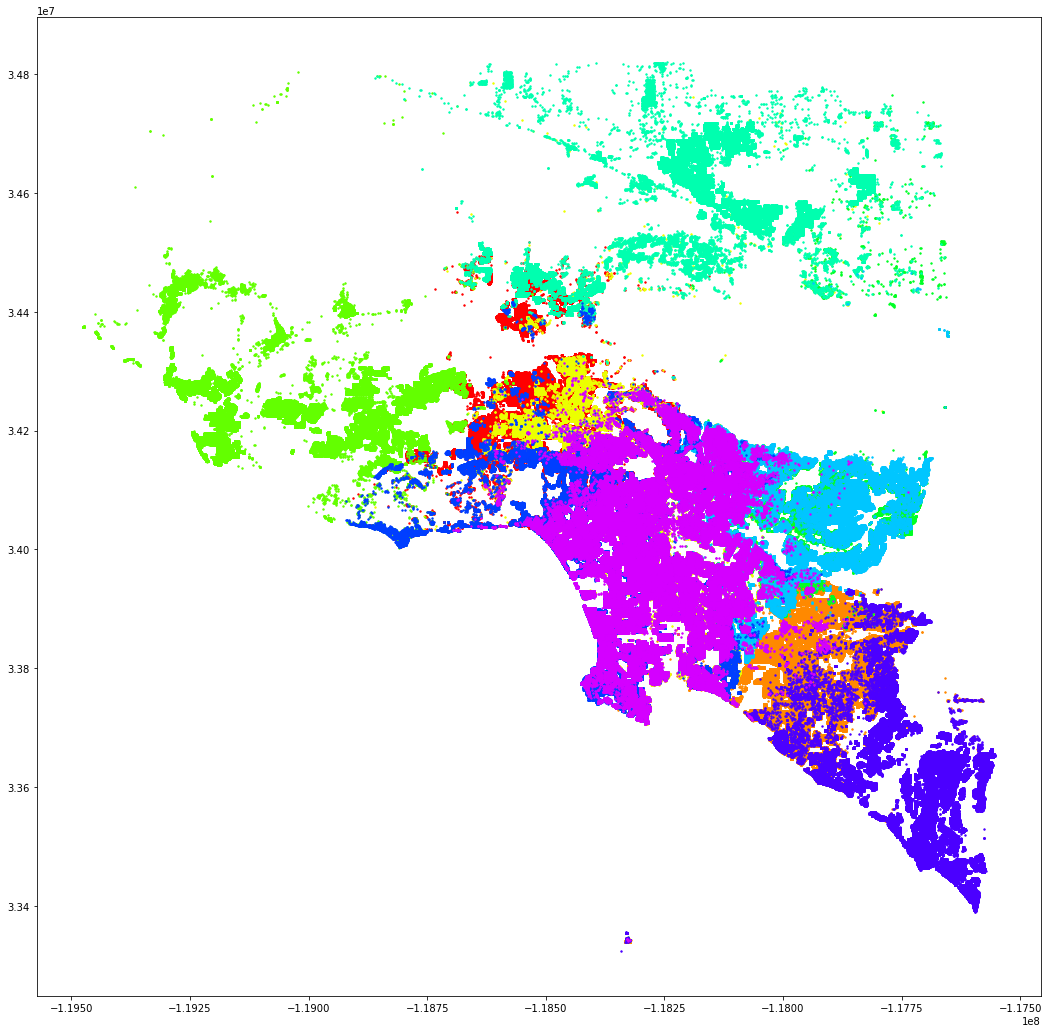

In [22]:
fig1, ax1 = plt.subplots(figsize=(18,18))
for i in range(n_clusters):
    lat = df_dropped1_label[df_dropped1_label['Label'] == i]["latitude"]
    long = df_dropped1_label[df_dropped1_label['Label'] == i]["longitude"]
    plt.scatter(long,lat,c=cmap(i), s=2.0)
    
#plt.scatter(centroid,np.zeros(n_clusters),c = 'r',marker = "x",s=300)
plt.show()

From the scatter plot, we noticed some interesting things. First, there are some geographical areas that the properties here are actually quite similar with each others, as we see there are clusters of the same color on the map. When we look at and compare with the real map, it seems like properties in surburban area of LA are similar, or have similar attributes. One exception is the Santa Monica and Berverly Hill area (purple area), which is an expensive area, at not too far from downtown LA, has very much similar properties. Other than that, the downtown area seems to have a mix scene, so the properties' attributes quite vary here.

## Task 4 (20%)

> - Identify at least one external data set which you can integrate into your price prediction analysis to make it better.  Perhaps it can be financial, such as the historical effects of interest rates, consumer confidence, etc. on housing prices.  Perhaps it can be geographic, like the crime rate, educational scores, income levels, etc.   
- Write a one page discussion/analysis on whether this data helps with the prediction tasks 


In [98]:
#reversing lat long
def reverseLatLong(lat, long):
    geolocator = Nominatim(timeout=10000)
    location = geolocator.reverse(str(lat) + ", " + str(long))
    return location

In [94]:
#centralizing zip
#drop all Nan and zero lat long
df_zip = df[np.isfinite(df["latitude"]) & np.isfinite(df["longitude"])]
df_zip = df_zip[df_zip["latitude"] != 0]
df_zip = df_zip[df_zip["longitude"] != 0]

In [95]:
(df_zip[["latitude", "longitude"]]/1000000).describe()

,latitude,longitude
count,2.982285e+06,2.982285e+06
mean,3.400131e+01,-1.182017e+02
std,2.435157e-01,3.455918e-01
min,3.332439e+01,-1.194758e+02
25%,3.382740e+01,-1.183929e+02
50%,3.400807e+01,-1.181721e+02
75%,3.416186e+01,-1.179489e+02
max,3.481965e+01,-1.175543e+02


In [101]:
#group and get 1 sample lat long by masked zip
mean_latlong = df.groupby("regionidzip", as_index=False)[["regionidzip", "latitude", "longitude"]].apply(lambda x :x.iloc[0])
mean_latlong = mean_latlong / 1000000
mean_latlong["address"] = 0
mean_latlong.describe()

,regionidzip,latitude,longitude,address
count,403.000000,403.000000,403.000000,403.0
mean,0.097231,34.019871,-118.226573,0.0
std,0.015109,0.241934,0.349818,0.0
min,0.095982,33.341610,-119.472551,0.0
25%,0.096134,33.843688,-118.386992,0.0
50%,0.096354,34.035689,-118.221492,0.0
75%,0.096964,34.163679,-117.978994,0.0
max,0.399675,34.814163,-117.588518,0.0


In [102]:
#DO NOT RUN THIS BLOCK UNLESS NESSESARY
#LIMIT: 2000 request perday
for index, row in mean_latlong.iterrows():
    ############################################################
    #UNCOMMENT THESE 2 LINES BELOWS IF POLLING ADDRESSES IS NEEDED
    #
    #
    #address = reverseLatLong(row["latitude"], row["longitude"]).address
    #mean_latlong["address"].iloc[index] = address
    if (index % 50 == 0):
        print("progress: ", index)
#mean_latlong
mean_latlong.to_csv("zip.csv")

progress:  0
progress:  50
progress:  100
progress:  150
progress:  200
progress:  250
progress:  300
progress:  350
progress:  400


In [129]:
mean_latlong.to_csv("zip.csv", index=False)

In [151]:
import re
#extract zipcode from address
zipToAd = pd.read_csv("zip.csv", encoding='cp1252')
zipToAd["regionidzip"] = zipToAd["regionidzip"] * 1000000
zipToAd["zipcode"] = 0
for index, row in zipToAd.iterrows():
    ad = row["address"]
    nums = re.findall(r"\d+", ad)
    for z in nums:
        if (int(z) >= 90000 and int(z) <= 99999):
            zipToAd["zipcode"].iloc[index] = int(z)
            break
zipToAd

,regionidzip,latitude,longitude,address,zipcode
0,95982.0,33.986747,-118.249544,"East 59th Street, Florence, LA, Los Angeles Co...",90001
1,95983.0,33.959485,-118.260716,"McKinley Avenue, Florence, LA, Los Angeles Cou...",90003
2,95984.0,33.976720,-118.268917,"East 69th Street, Florence, LA, Los Angeles Co...",90003
3,95985.0,34.077572,-118.286239,"Los Angeles Fire Department Fire Station 6, 32...",90004
4,95986.0,34.060448,-118.330973,"South Mullen Avenue, Hancock Park, Cienega, LA...",90028
5,95987.0,34.040347,-118.284504,"West Washington Boulevard, Saint James Park, L...",90015
6,95988.0,34.022485,-118.296811,"West 36th Street, Jefferson Park, Cienega, LA,...",90018
7,95989.0,34.002190,-118.341249,"Mount Vernon Drive, View Park, View Park–Winds...",90043
8,95991.0,34.061500,-118.326000,"Fremont Place, Hancock Park, Cienega, LA, Los ...",90028
9,95992.0,33.992162,-118.271355,"East 55th Street, Florence, LA, Los Angeles Co...",90011


Ventura County, California, United States of America
Wheeler Road, San Bernardino County, California, United States of America


## Task 5 (20%)

> - Finally, build the best prediction model you can to solve the Zillow task.  Use any data, ideas, and approach that you like. Predict the logerror for instances at file “sample_submission.csv”.  
- Report the score/rank you get. 
- Write a 2-3 page report about how it works, an evaluation, and any interesting experiences along the way.  



## Task 6 (15%)

> - Do a permutation test to determine a p-value of how good your predictions of logerror are.  You can use whatever metric you wish to score your model (like mean absolute error).   
- For a large enough sample of the evaluation data, compare how your model ranks by this metric on the real data compared to 100 (or more) random permutations of the logerror assigned to the real data records. 
- What fraction of permutations produce at least error at least as good at the real data set?   If necessary, sample your data so these 100+ runs do not take too much time. 




## Task 7 (10%)

> Submit your results on the real test data to Kaggle before deadline. Write the result into a csv file and submit it to the website. Actually, submit two for your two best models, to the extent that Zillow allows it.   


